# Model Calibration

In [1]:
import household_contact_tracing as hct
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import seaborn as sns
import pandas as pd
import scipy.stats as ss
from patsy import dmatrices
import statsmodels.api as sma

The model calibration class inherits from the base model class, so you are using the exact same code/distributions. The calibration estimates the $R_0$ of the model using the Lorenzo's household R_0 paper. The local and global infections are simulated, hence there is uncertainty in the output.

In order to tune the models, we estimate the R_0 over a variety of inputs, and fits a quick linear regression to the outputs.

Note: The calculation can produce some crazy values if the inputs aren't realistic, this is a minor issue for now.

## Calibrating the household secondary attack rate

In [2]:
model_calibrator = hct.model_calibration(haz_rate_scale = 0.795,
                                            contact_tracing_success_prob = 2/3,
                                            overdispersion = 0.36,
                                            infection_reporting_prob = 0.2,
                                            contact_trace_delay_par = 3,
                                            contact_trace = False,
                                            reduce_contacts_by = 0,
                                            starting_infections = 1000)

In [3]:
%%time
model_calibrator.estimate_secondary_attack_rate()

Wall time: 5.62 s


0.22557122022362663

In [8]:
secondary_attack_rates = []
for x in np.linspace(0.7, 0.9):
    model_calibrator = hct.model_calibration(haz_rate_scale = x,
                                            contact_tracing_success_prob = 2/3,
                                            overdispersion = 0.36,
                                            infection_reporting_prob = 0.2,
                                            contact_trace_delay_par = 3,
                                            contact_trace = False,
                                            reduce_contacts_by = 0,
                                            starting_infections = 1000)
    secondary_attack_rates.append(model_calibrator.estimate_secondary_attack_rate())
    
data = pd.DataFrame({"household_hazard_rate_scale": np.linspace(0.7, 0.9),
                     "secondary_attack_rate": secondary_attack_rates})

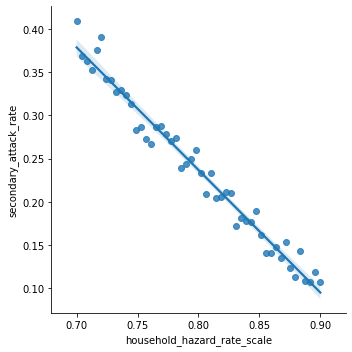

In [13]:
sns.lmplot("household_hazard_rate_scale", "secondary_attack_rate", data = data)

In [14]:
y, X = dmatrices('secondary_attack_rate ~ household_hazard_rate_scale', 
                 data = data)
model_1 = sma.OLS(y, X)
res = model_1.fit()
print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     secondary_attack_rate   R-squared:                       0.971
Model:                               OLS   Adj. R-squared:                  0.970
Method:                    Least Squares   F-statistic:                     1609.
Date:                   Sat, 02 May 2020   Prob (F-statistic):           1.42e-38
Time:                           15:45:00   Log-Likelihood:                 140.98
No. Observations:                     50   AIC:                            -278.0
Df Residuals:                         48   BIC:                            -274.1
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [15]:
def solve_for_x(y, res):
    c = res.params[0]
    m = res.params[1]
    
    return (y - c) / m

A secondary household attack rate of 35% requires the hazard rate scaling to be around 0.722

In [16]:
solve_for_x(0.35, res)

0.7201266849708313

### We now have the hazard rate that leads to correctly assumed within household dynamics

In practice we use the script "tune_R0.py" to estimate the $R_0$ value for a range of different inputs, however we demonstrate this below.

In [22]:
household_hazard_rate = solve_for_x(0.35, res)

In [23]:
model_calibrator = hct.model_calibration(haz_rate_scale = 0.81,
                                         household_haz_rate_scale = household_hazard_rate,
                                         contact_tracing_success_prob = 0,
                                         overdispersion = 0.36,
                                         infection_reporting_prob = 0.2,
                                         contact_trace_delay_par = 3,
                                         contact_trace = False,
                                         reduce_contacts_by = 0)

In [ ]:
model_calibration.calculate_R0()

In [80]:
x_vals = np.linspace(0.79, 0.81, 5)
repetitions = 1
hazard_rate_scale = []
R0_estimate = []
for x in x_vals:
    model_calibration = model.model_calibration(haz_rate_scale = x,
                                                household_haz_rate_scale = household_hazard_rate,
                                                contact_tracing_success_prob = 2/3,
                                                contact_trace_delay_par = 1/3,
                                                overdispersion = 0.36,
                                                infection_reporting_prob = 0.7,
                                                contact_trace = True,
                                                reduce_contacts_by = 0)
    for repeat in range(repetitions):
        print(f"x values : {x}   repeat: {repeat}", end = "\r")
        hazard_rate_scale.append(x)
        R0_estimate.append(model_calibration.calculate_R0())

In [26]:
data = pd.read_excel("Data/calibration_R0_vals.xlsx")

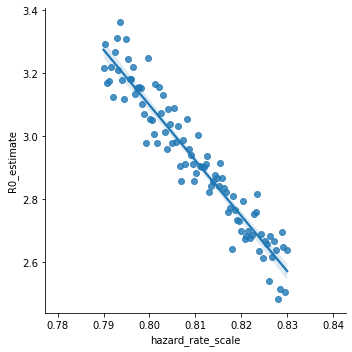

In [27]:
plot = sns.lmplot("hazard_rate_scale", "R0_estimate", data)

## Distribution of secondary infections

In [29]:
model_calibrator = hct.model_calibration(haz_rate_scale = 0.81,
                                         contact_tracing_success_prob = 0,
                                         household_haz_rate_scale = 0.72219,
                                         overdispersion = 0.36,
                                         infection_reporting_prob = 0.2,
                                         contact_trace_delay_par = 3,
                                         contact_trace = False,
                                         reduce_contacts_by = 0,
                                         starting_infections = 1000)

out = model_calibrator.generate_secondary_infection_distribution()

Text(0.5, 1.0, 'Distribution of Infections Caused')

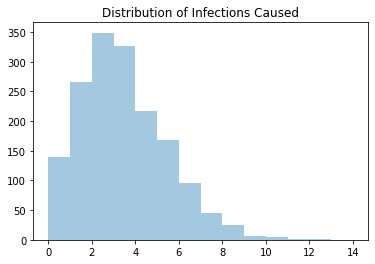

In [31]:
sns.distplot(out, bins = range(15), kde = False)
plt.title("Distribution of Infections Caused")